<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from sklearn.model_selection import cross_val_score, train_test_split #GridSearchCV, 
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Function to create the pretty confusion matrix
#
# From matplotlib's official documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

> [This](https://ww2.amstat.org/publications/jse/v19n3/decock/datadocumentation.txt) is a slightly better data dictionary. With information on the number of continous, ordinal, nominal and discrete columns.

In [3]:
# Load the data
#
# keep_default_na=False is critical here. NA in the cell means No Basement, No Fence, No Pool etc. and not NaN
house = pd.read_csv('./housing.csv', keep_default_na=False)

In [4]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [5]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [6]:
pd.set_option('max_columns', 82)

In [7]:
house.shape

(1460, 81)

In [8]:
# house.info() # print at your peril!

In [9]:
# Extract all residential data
df = house.loc[house['MSZoning'].isin(['FV','RH','RL','RP','RM'])==True].copy()

In [10]:
# Drop "New" type of SaleType
df = df[~df['SaleType'].isin(['New'])]

# Drop "Family" transactions

df = df[~df['SaleCondition'].isin(['Family'])]

In [11]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [12]:
df.shape

(1308, 81)

In [13]:
1460-1308

152

> I have dropped about 152 rows here. I hope I don't regret this later on.

In [14]:
#df.info() # print at your peril!

In [15]:
df.dtypes.value_counts()

object    46
int64     35
dtype: int64

In [16]:
# The continous columns: LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, GarageArea,
# WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, SalePrice

In [17]:
continuous_columns = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',\
                      'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

In [18]:
cont_df = df[continuous_columns].copy()

In [19]:
cont_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308 entries, 0 to 1459
Data columns (total 20 columns):
LotFrontage      1308 non-null object
LotArea          1308 non-null int64
MasVnrArea       1308 non-null object
BsmtFinSF1       1308 non-null int64
BsmtFinSF2       1308 non-null int64
BsmtUnfSF        1308 non-null int64
TotalBsmtSF      1308 non-null int64
1stFlrSF         1308 non-null int64
2ndFlrSF         1308 non-null int64
LowQualFinSF     1308 non-null int64
GrLivArea        1308 non-null int64
GarageArea       1308 non-null int64
WoodDeckSF       1308 non-null int64
OpenPorchSF      1308 non-null int64
EnclosedPorch    1308 non-null int64
3SsnPorch        1308 non-null int64
ScreenPorch      1308 non-null int64
PoolArea         1308 non-null int64
MiscVal          1308 non-null int64
SalePrice        1308 non-null int64
dtypes: int64(18), object(2)
memory usage: 214.6+ KB


In [20]:
# LotFrontage and MasVnrArea should be int64...
cont_df['LotFrontage'].str.contains('NA').sum()

256

In [21]:
cont_df['MasVnrArea'].str.contains('NA').sum()

5

In [22]:
cont_df.replace(to_replace='NA', value=0, inplace=True)

In [23]:
cont_df = cont_df.apply(pd.to_numeric)

In [24]:
# Discrete columns: YearBuilt, YearRemodAdd, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Bedroom, Kitchen, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, 
# MoSold, and YrSold

In [25]:
discrete_columns = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',\
                    'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'SalePrice']

In [26]:
discrete_df = df[discrete_columns].copy()

In [27]:
discrete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308 entries, 0 to 1459
Data columns (total 15 columns):
YearBuilt       1308 non-null int64
YearRemodAdd    1308 non-null int64
BsmtFullBath    1308 non-null int64
BsmtHalfBath    1308 non-null int64
FullBath        1308 non-null int64
HalfBath        1308 non-null int64
BedroomAbvGr    1308 non-null int64
KitchenAbvGr    1308 non-null int64
TotRmsAbvGrd    1308 non-null int64
Fireplaces      1308 non-null int64
GarageYrBlt     1308 non-null object
GarageCars      1308 non-null int64
MoSold          1308 non-null int64
YrSold          1308 non-null int64
SalePrice       1308 non-null int64
dtypes: int64(14), object(1)
memory usage: 163.5+ KB


In [28]:
discrete_df['GarageYrBlt'].str.contains('NA').sum()

77

In [29]:
discrete_df.replace(to_replace='NA', value=0, inplace=True)

In [30]:
discrete_df = discrete_df.apply(pd.to_numeric)

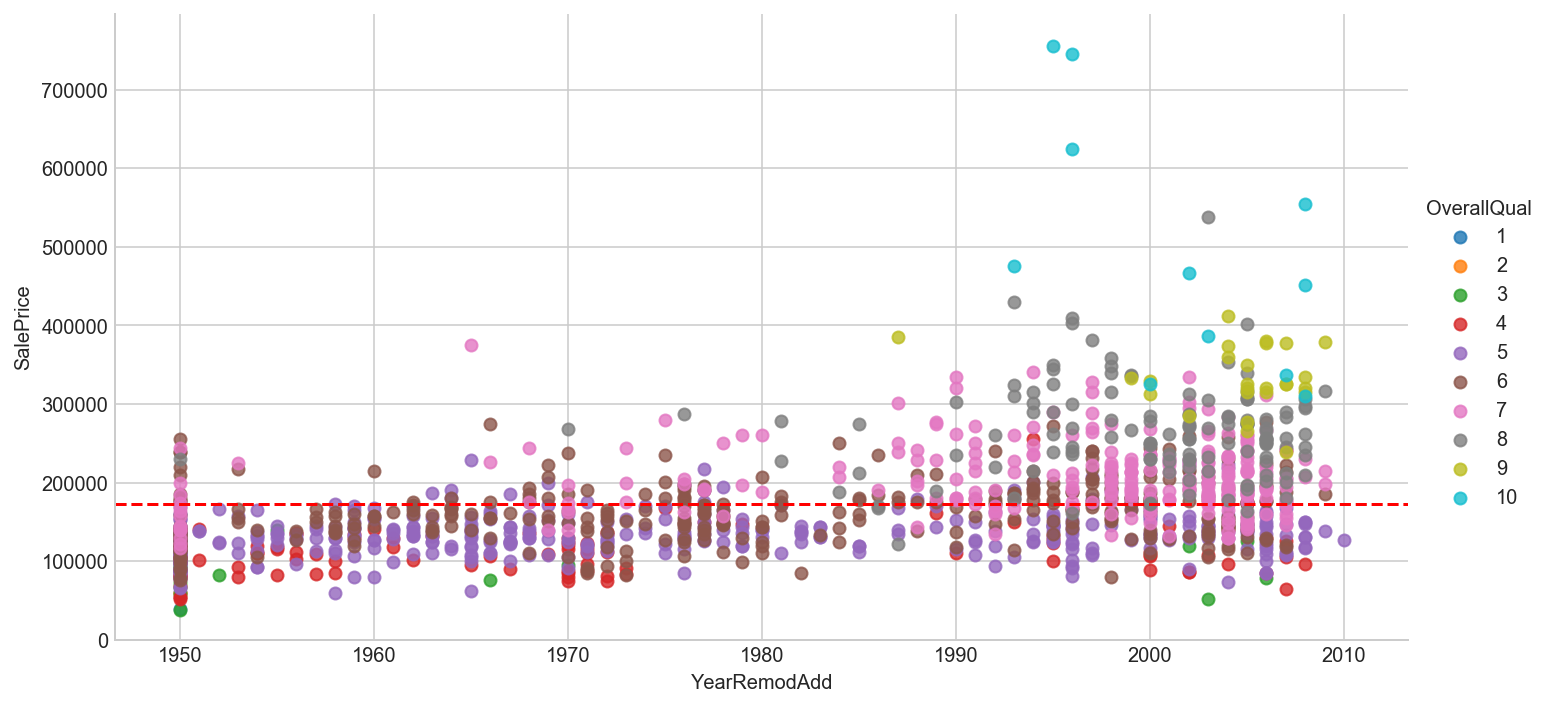

In [31]:
sns.lmplot(data=df, x='YearRemodAdd', y='SalePrice', hue='OverallQual', fit_reg=False, size=5, aspect=2)
plt.axhline(y=np.mean(df['SalePrice']), linestyle='dashed', color='r', label='Mean of Sale Price')
plt.show()

In [32]:
# Replace all the NAs with 0s in the main df
df[['LotFrontage','MasVnrArea','GarageYrBlt']] = df[['LotFrontage','MasVnrArea','GarageYrBlt']].replace(to_replace='NA', value=-99999)
df[['LotFrontage','MasVnrArea','GarageYrBlt']] = df[['LotFrontage','MasVnrArea','GarageYrBlt']].apply(pd.to_numeric)

In [33]:
df.dtypes.value_counts()

object    43
int64     38
dtype: int64

In [34]:
# MSSubClass shouldn't be an int64 column...
df['MSSubClass'] = df['MSSubClass'].astype('object')

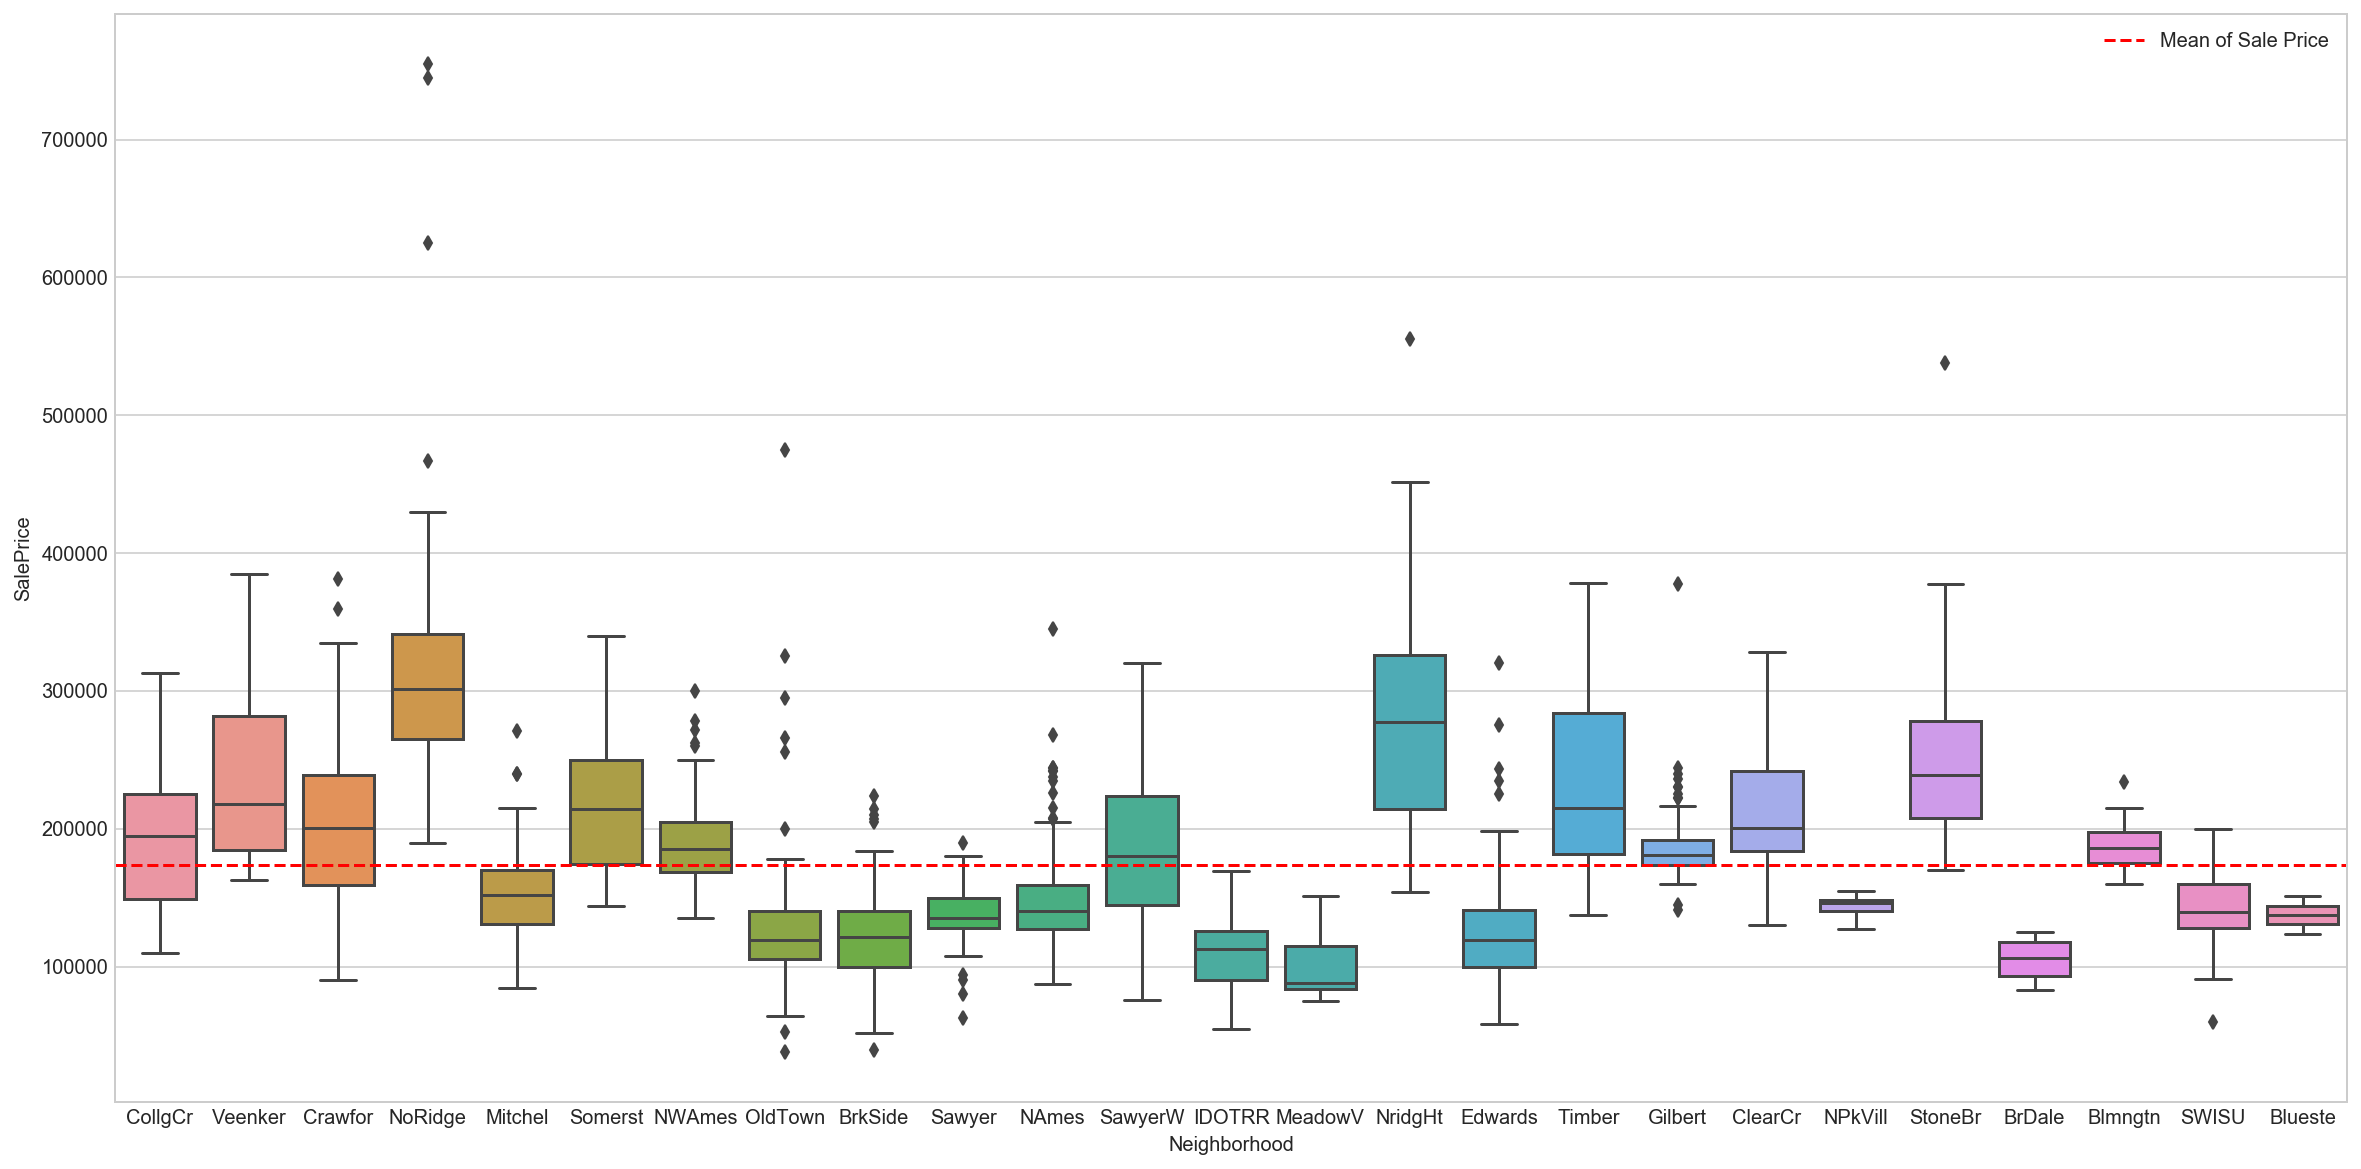

In [35]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='Neighborhood', y='SalePrice')
plt.axhline(y=np.mean(df['SalePrice']), linestyle='dashed', color='r', label='Mean of Sale Price')
plt.legend(loc='upper right')
plt.show()

In [36]:
# Taking the mean of each group. Sum() might be affected by outliers...
# df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).to_frame('Mean_SalePrice_per_Neigh').reset_index().head(10)

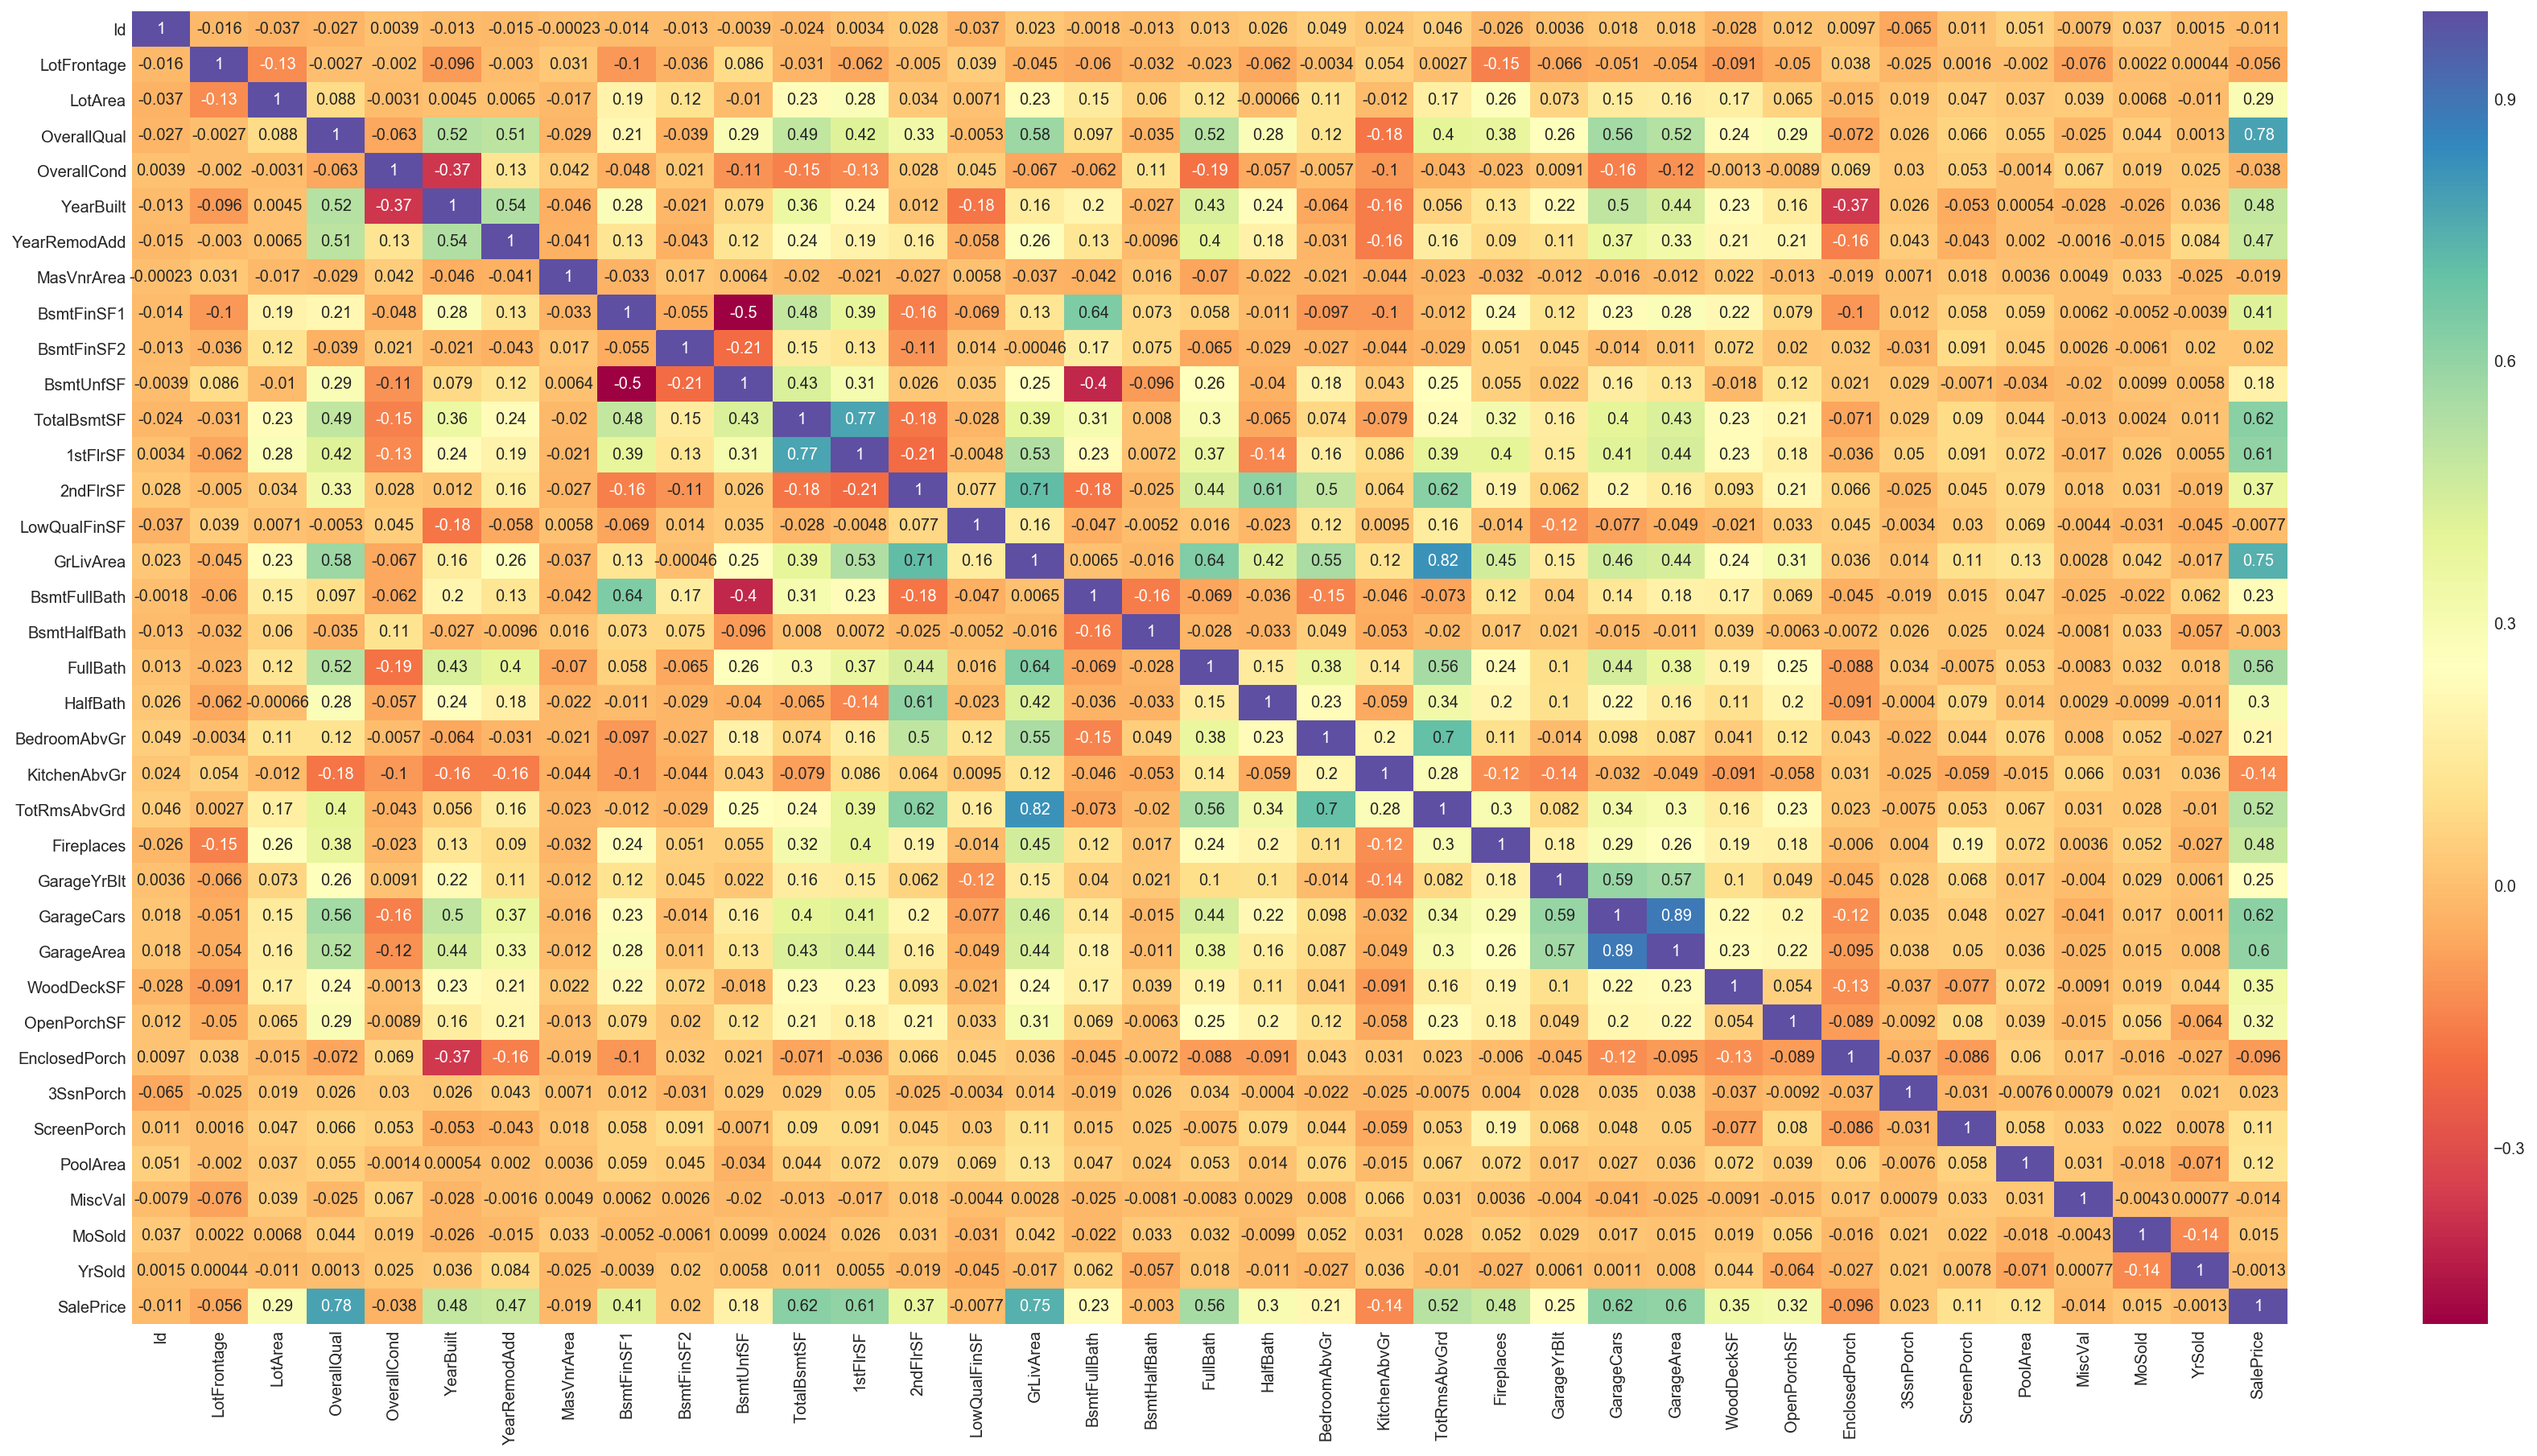

In [37]:
# plot bigger heatmap
plt.figure(figsize=(30,15))
sns.heatmap(df.corr(), annot=True, cmap='Spectral')
plt.show()

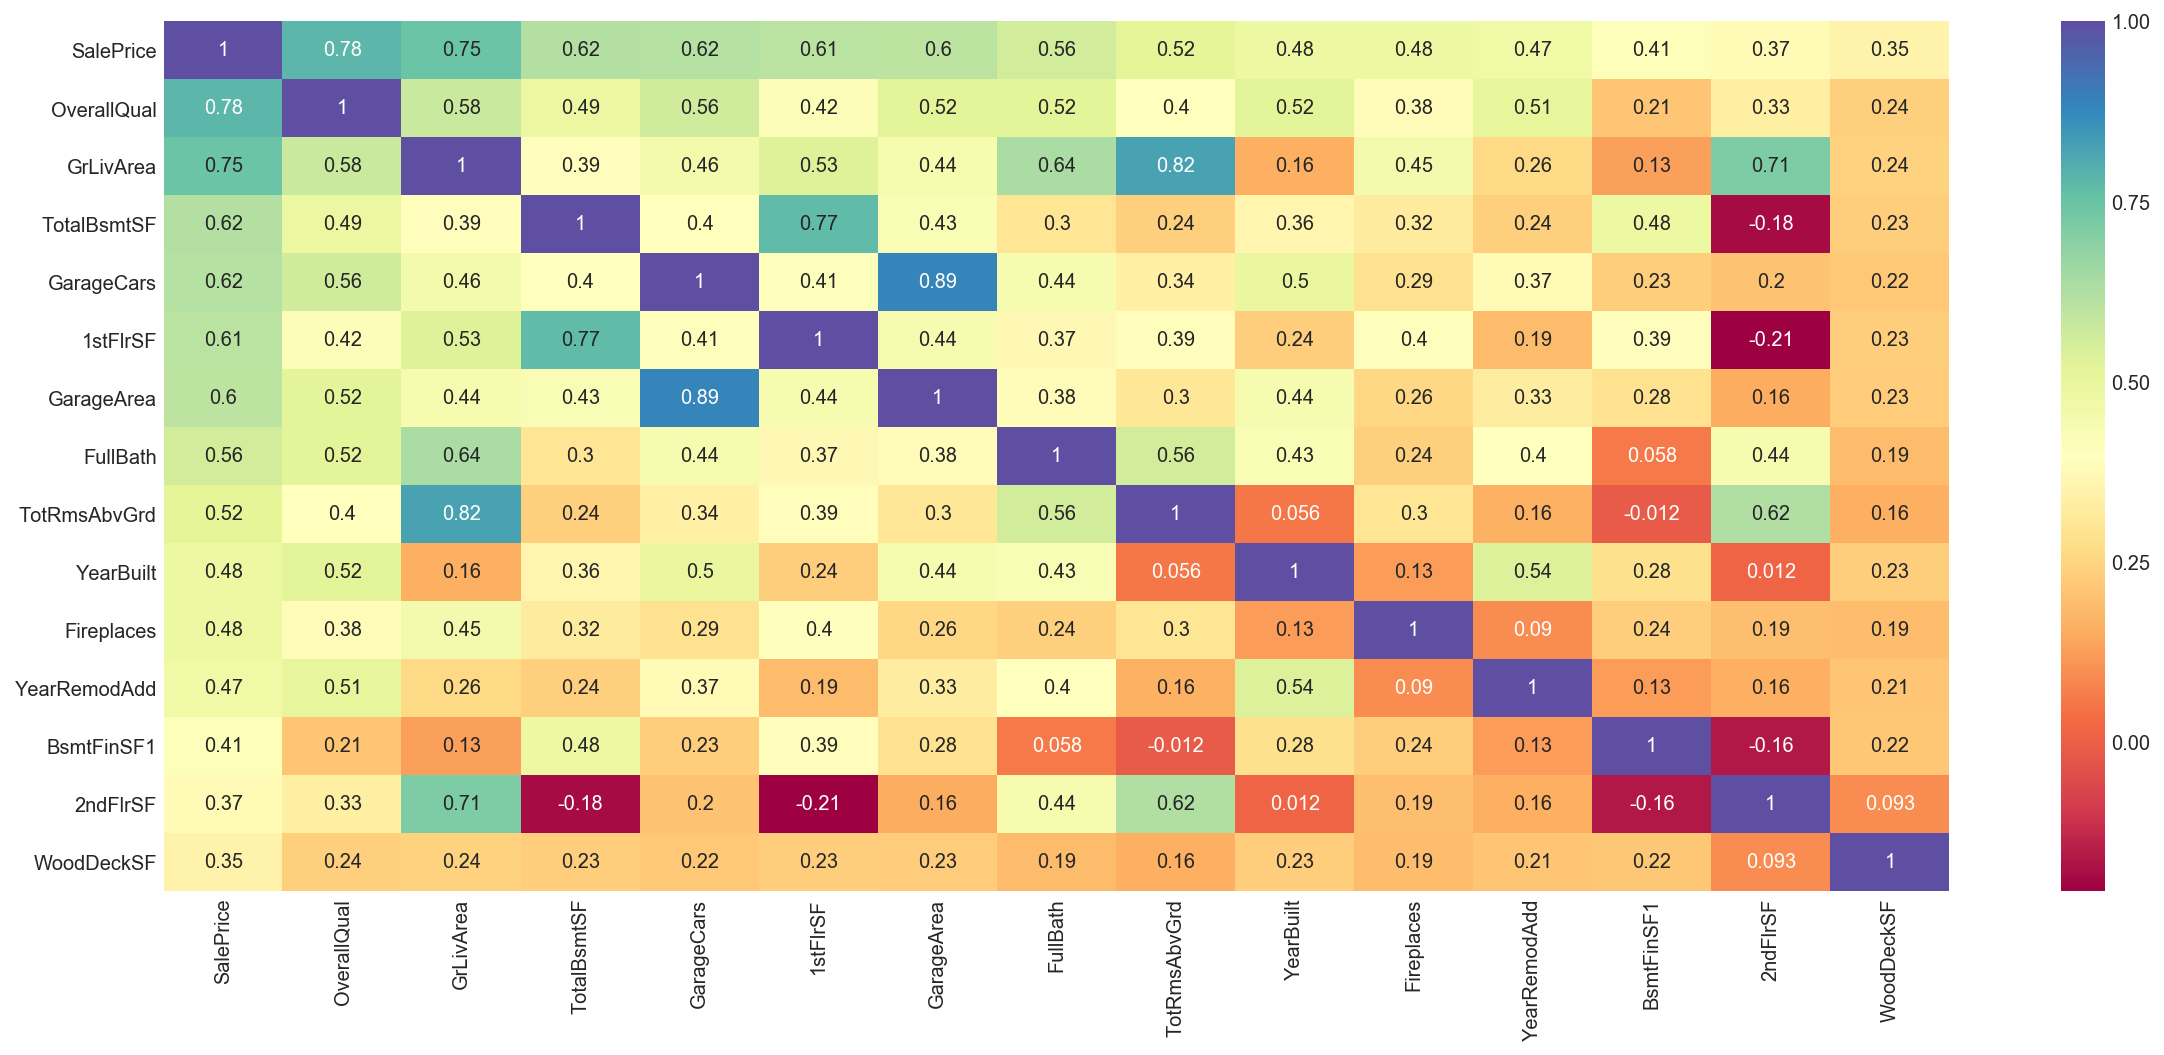

In [38]:
# Lifted from one of the posts on Kaggle. I take no credit. The only change is k=15 instead of k=10
#
# SalePrice correlation matrix
k = 15 #number of variables for heatmap
cols = df.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)

plt.figure(figsize=(20,8))
sns.heatmap(cm, annot=True, yticklabels=cols.values, xticklabels=cols.values, cmap='Spectral')
plt.show()

> So the variables that are likely to make a difference are:
> - OverallQual
> - GrLivArea (TotRmsAbvGrd is highly correlated with GrLiveArea, which makes sense--I will take GrLivArea cause of the continuous values)
> - GarageArea (because GarageCars and Area are kinda the same thing, I'll take the continous variable instead of the discrete values)
> - TotalBsmtSF
> - 1stFlrSF
> - FullBath
> - YearBuilt and YearRemodAdd (I think at this point, one of these will matter more... not both, for now I will take YearRemodAdd)

> Features that cannot be renovated:
> - GrLivArea
> - GarageArea
> - TotalBsmtSF
> - 1stFlrSF
> - FullBath (D)
> - YearBuilt 
> - BsmtQual (C)
> - Neighborhood (C)

> ----
> **Baseline**
>
> Using these selected features, we'll use a simple LinearRegression() with no optimization to see what is the score. This can be our baseline.

In [39]:
# Prepare the train and test sets

In [40]:
list_of_features = ['SalePrice','YrSold','GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','BsmtQual','Neighborhood']
features = df[list_of_features].copy()
features = pd.get_dummies(data=features, columns=['FullBath','BsmtQual','Neighborhood'], drop_first=True)
features.shape

(1308, 38)

In [41]:
train = features[features['YrSold']<2010]

In [42]:
train.shape

(1145, 38)

In [43]:
test = features[features['YrSold']==2010]

In [44]:
test.shape

(163, 38)

In [45]:
# Drop YrSold column since we don't need it anymore
train = train.drop(columns=['YrSold'])
test = test.drop(columns=['YrSold'])

In [46]:
X_train = train.iloc[:,1:]
y_train = train['SalePrice'].values

In [47]:
X_test = test.iloc[:,1:]
y_test = test['SalePrice'].values

In [48]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [49]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.8636720677437293

In [50]:
lr.intercept_

173486.7965065502

In [51]:
lr_coef_df = pd.DataFrame({'labels':test.columns.values[1:],'coef':lr.coef_,'absolute_coef':np.abs(lr.coef_)})

In [52]:
lr_coef_df.sort_values(by='coef', ascending=True).head()

,absolute_coef,coef,labels
11,29796.869570,-29796.869570,BsmtQual_TA
9,24686.056834,-24686.056834,BsmtQual_Gd
8,10268.532724,-10268.532724,BsmtQual_Fa
10,9137.727440,-9137.727440,BsmtQual_NA
6,5854.335030,-5854.335030,FullBath_2


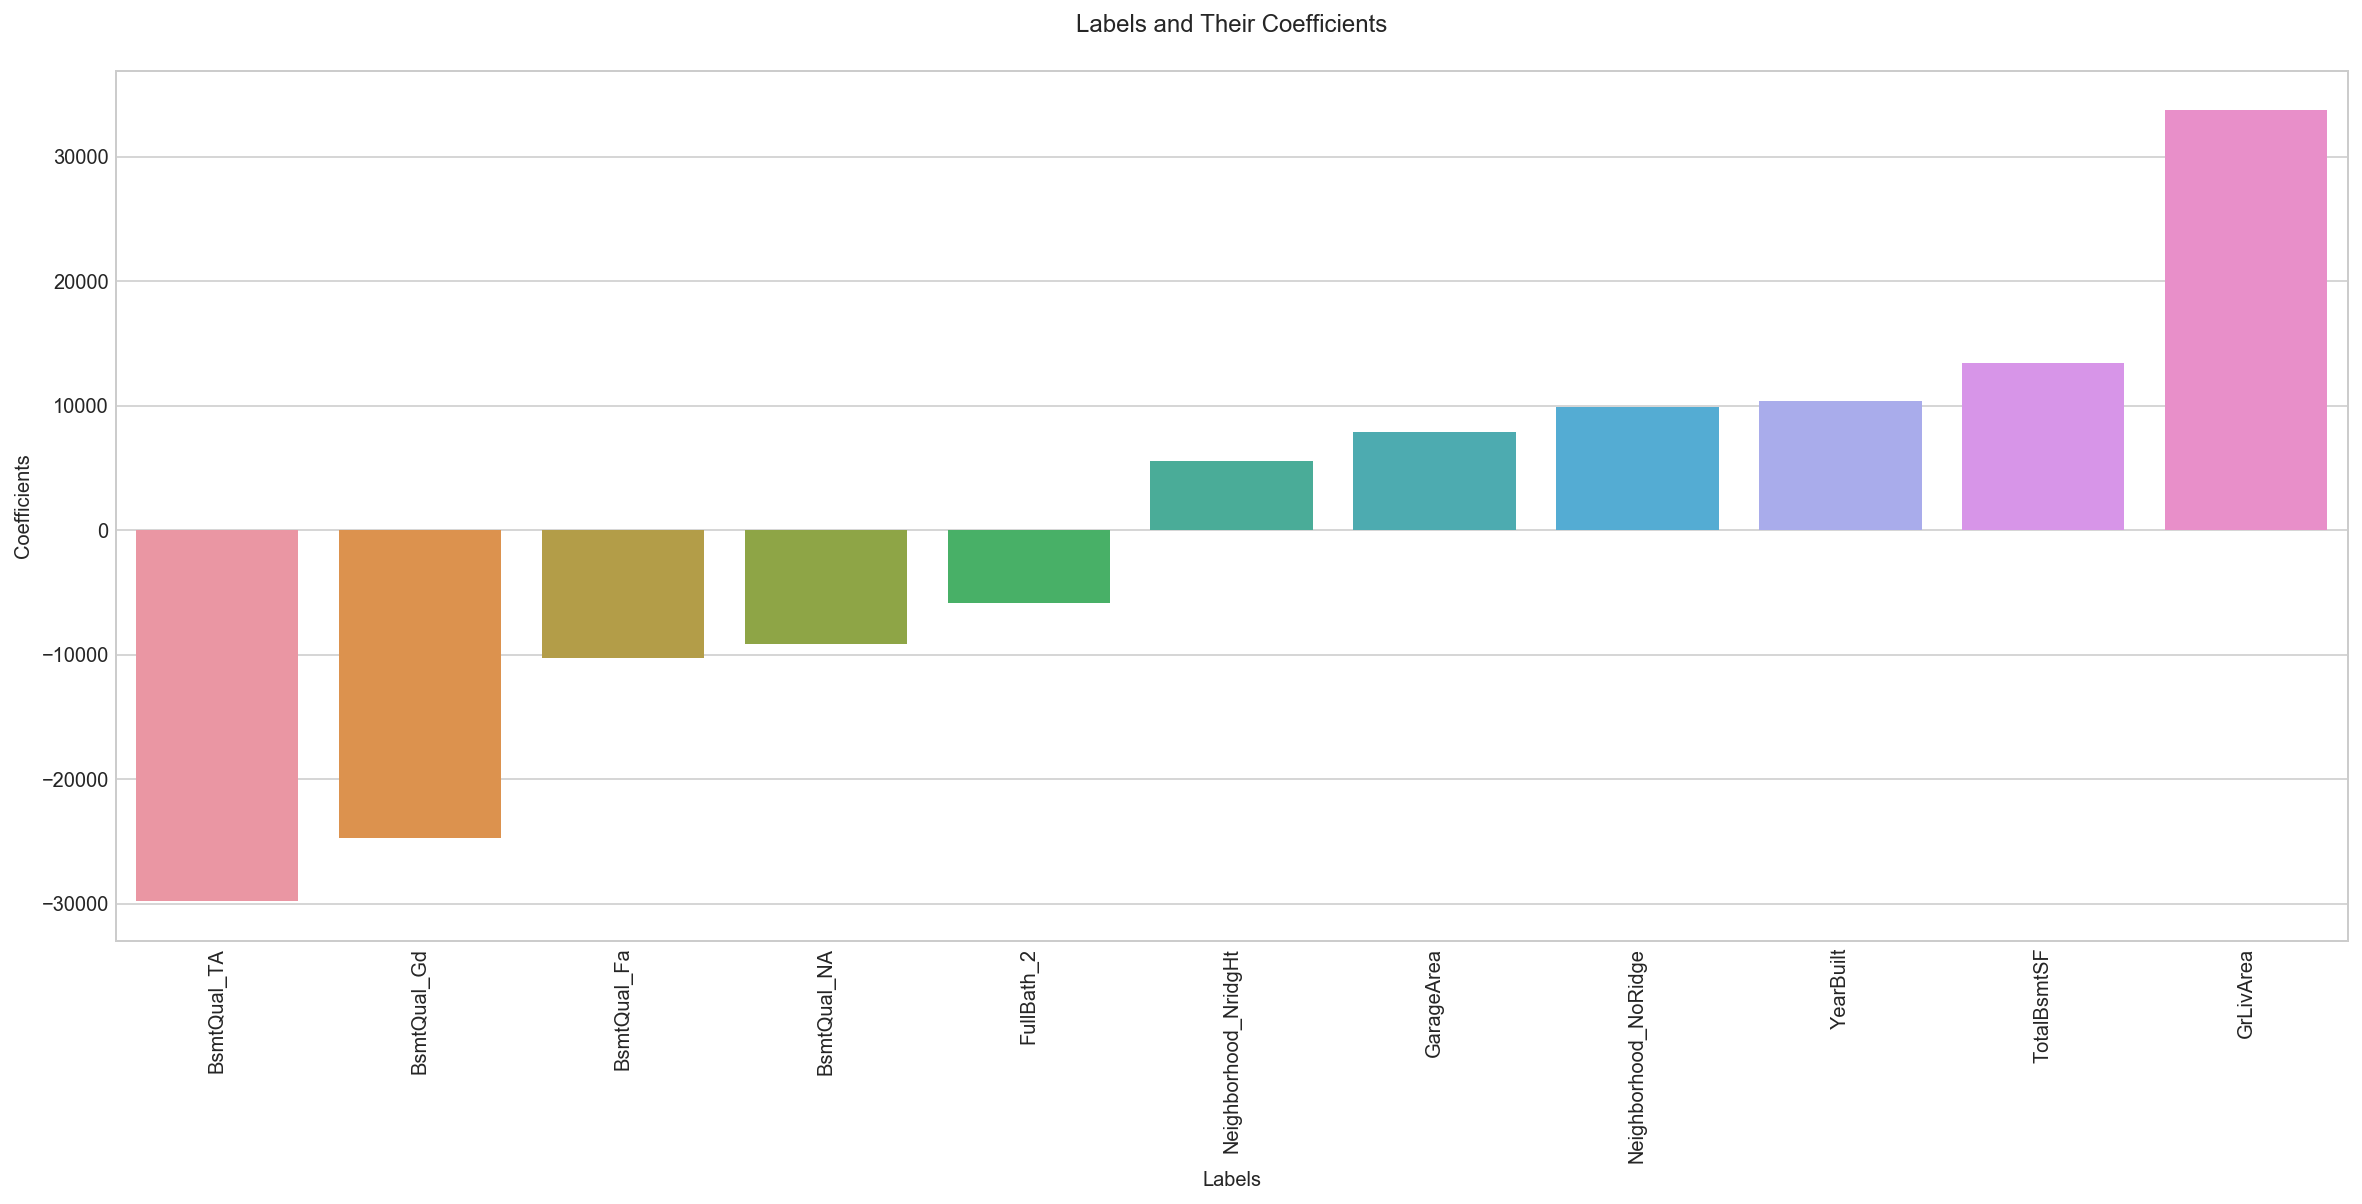

In [53]:
plt.figure(figsize=(20,8))
sns.barplot(data=lr_coef_df[(lr_coef_df['absolute_coef']!=0) & (lr_coef_df['absolute_coef']>5000)].sort_values(by='coef', ascending=True), x='labels', y='coef')

plt.title('Labels and Their Coefficients\n')
plt.ylabel('Coefficients')
plt.xlabel('Labels')
plt.xticks(rotation='vertical')
plt.show()

In [54]:
lr_yhat = lr.predict(X_test)

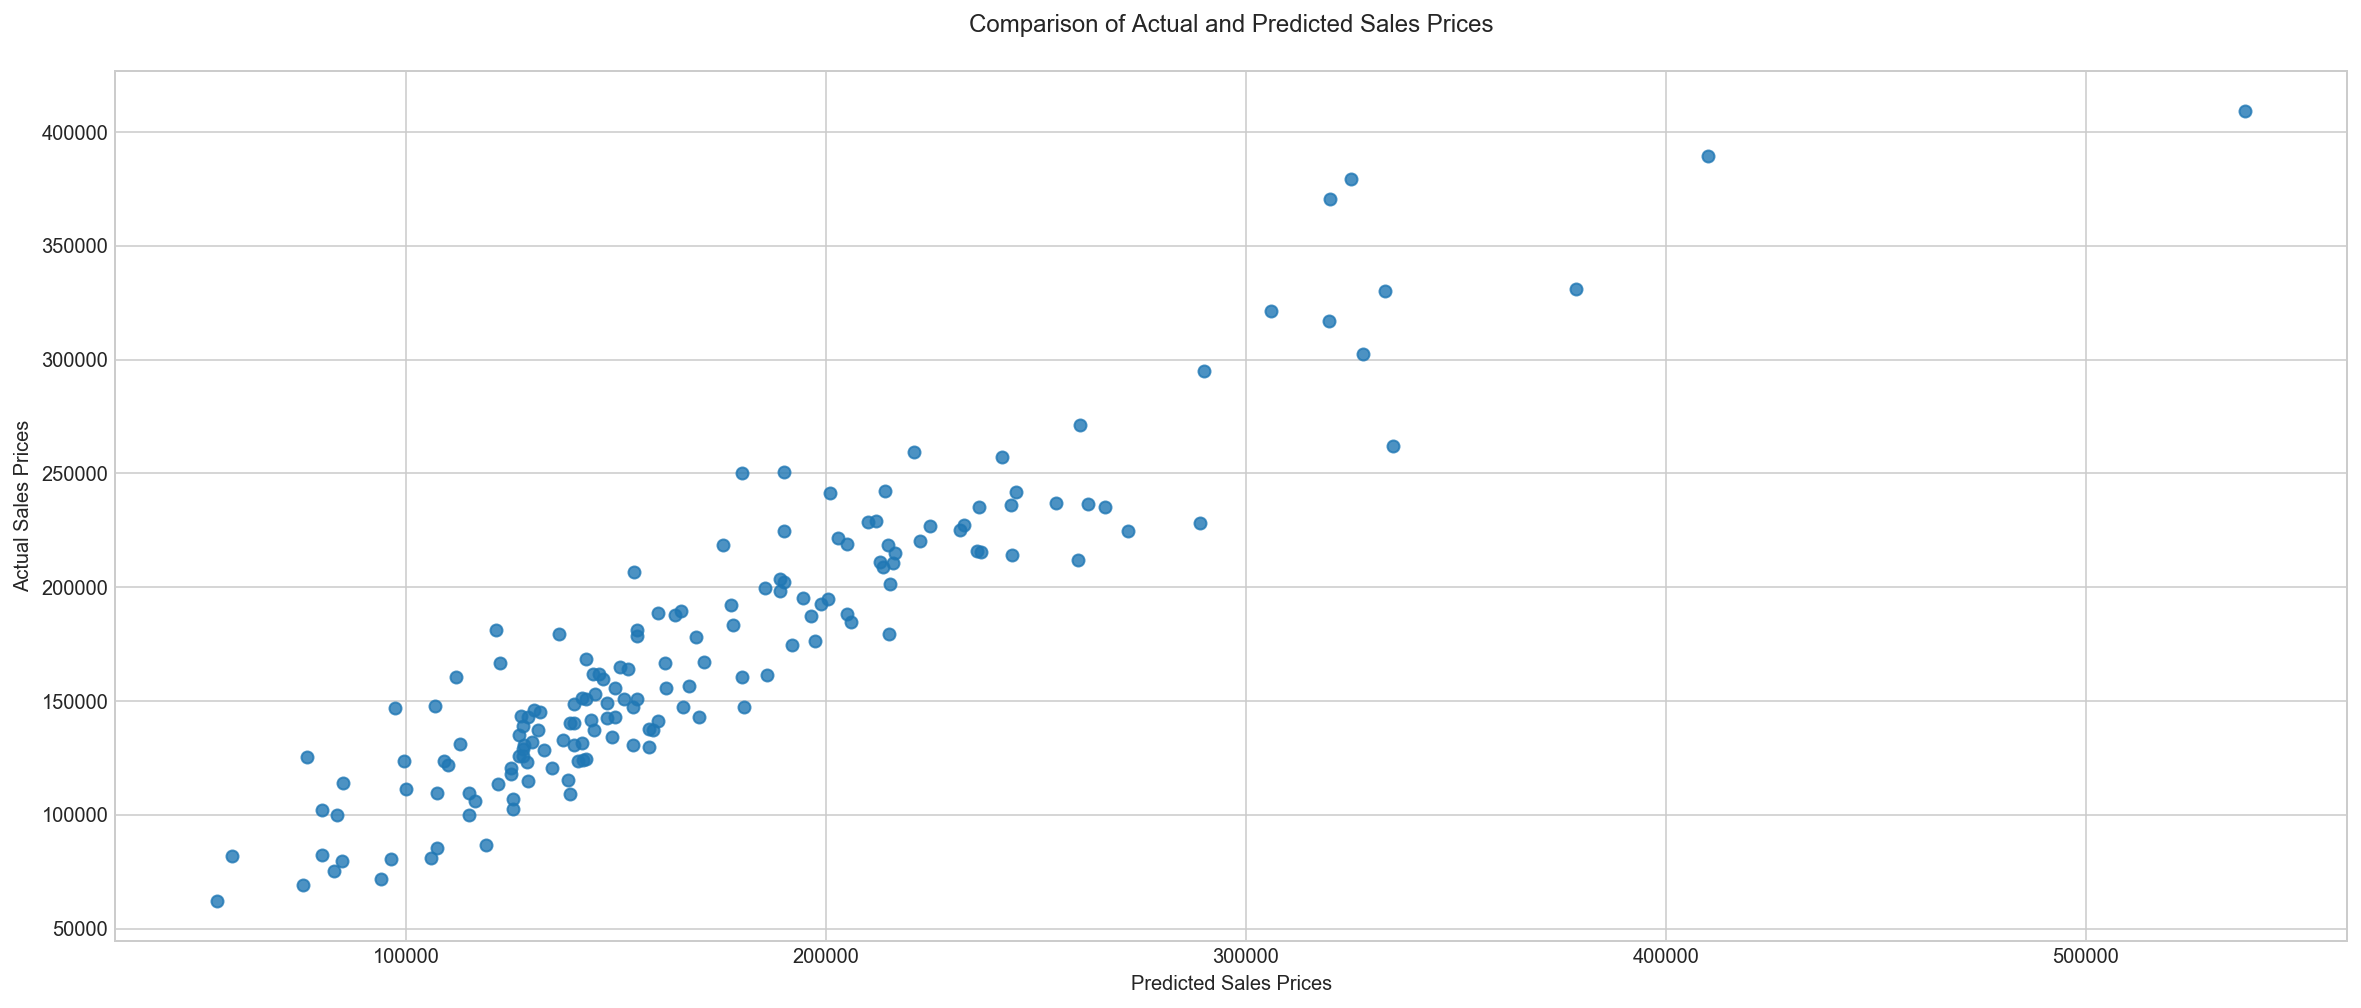

In [55]:
plt.figure(figsize=(20,8))
sns.regplot(x=y_test, y=lr_yhat, fit_reg=False)

plt.title('Comparison of Actual and Predicted Sales Prices\n')
plt.xlabel('Predicted Sales Prices')
plt.ylabel('Actual Sales Prices')
plt.show()

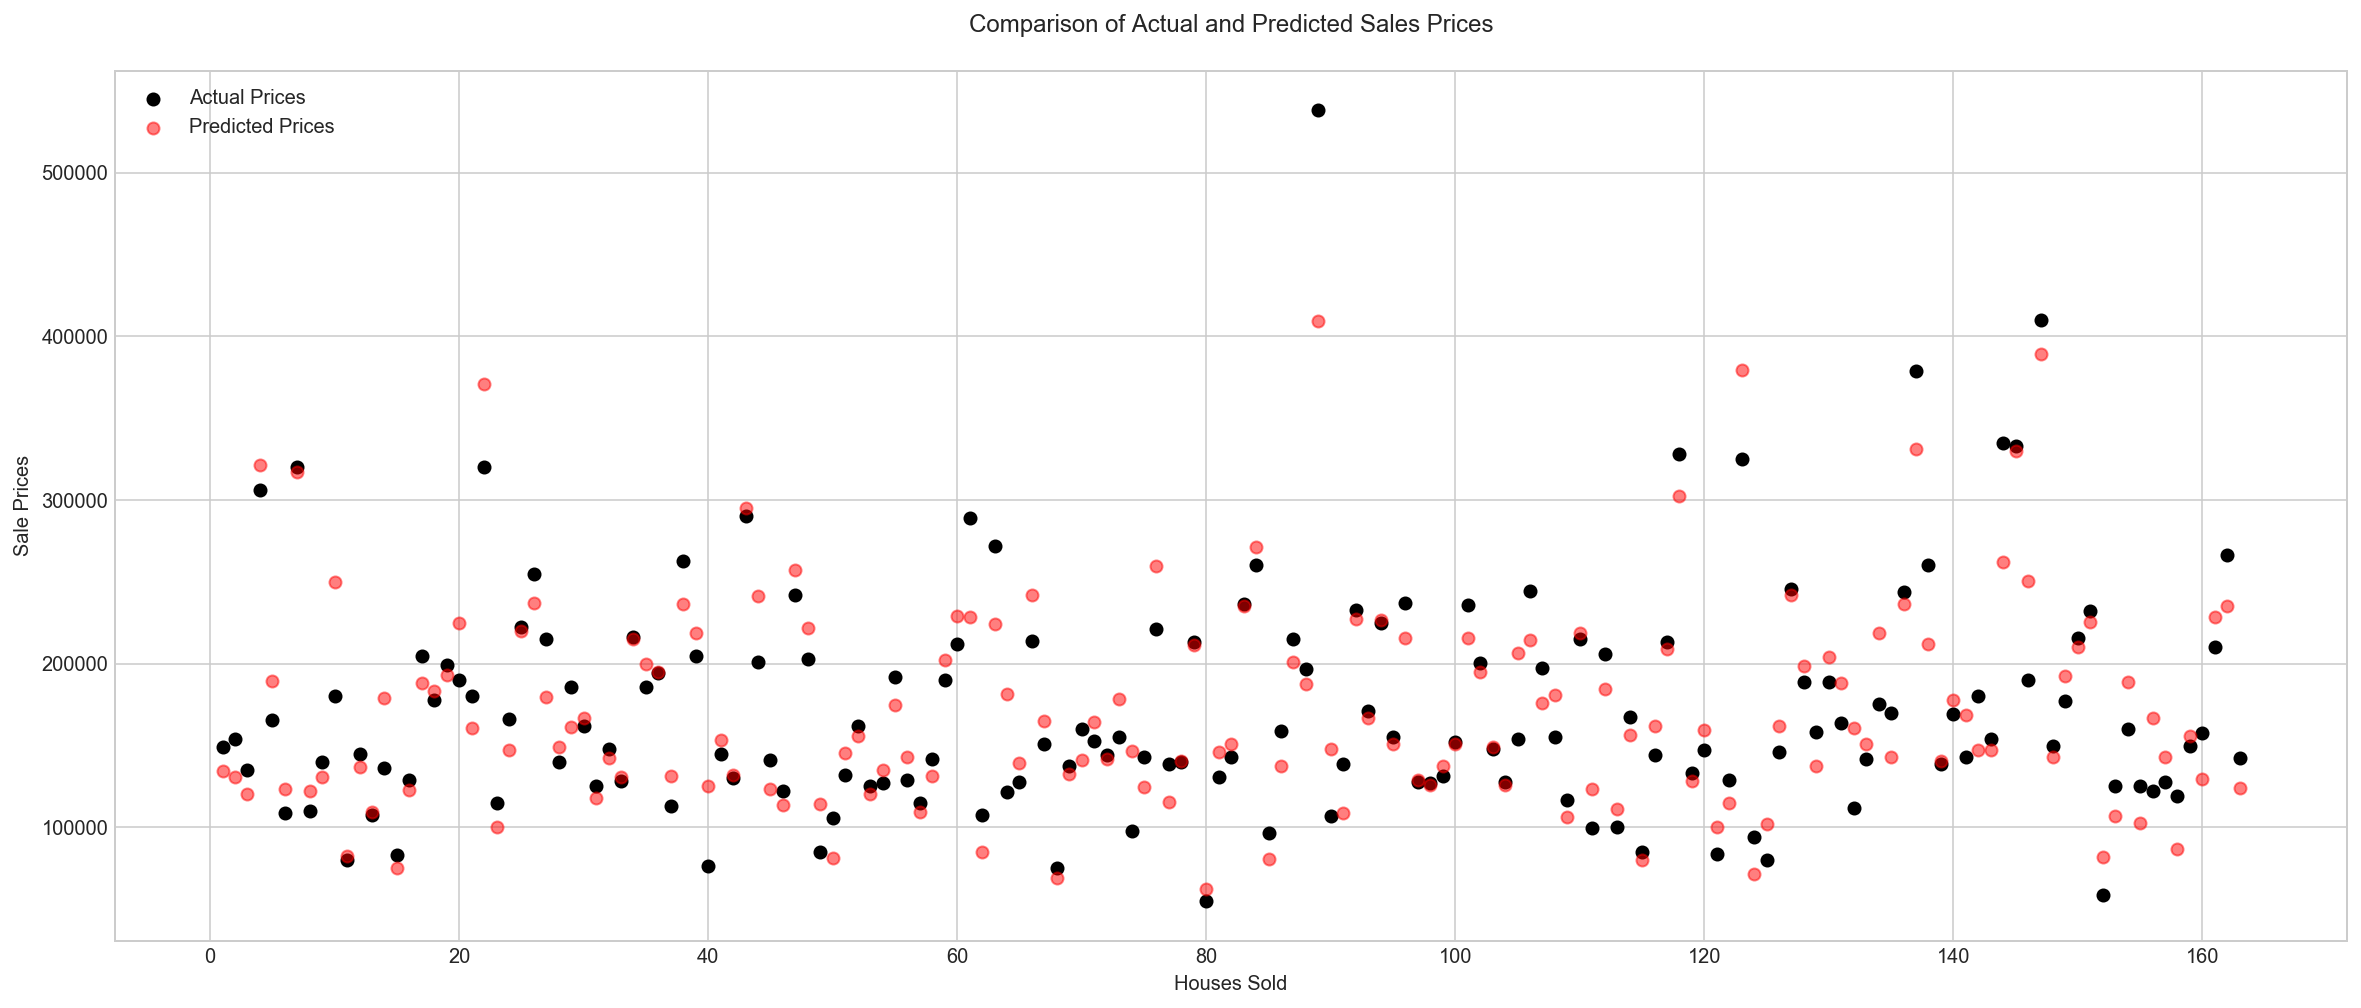

Mean squared error: 656910169.149
R^2: 0.863672067744
This is our baseline.


In [56]:
plt.figure(figsize=(20,8))
plt.scatter(range(1,164), y_test,  color='black', label='Actual Prices')
plt.scatter(range(1,164), lr_yhat, color='red', alpha=0.5, label='Predicted Prices')

plt.legend(loc='upper left')

plt.title('Comparison of Actual and Predicted Sales Prices\n')
plt.xlabel('Houses Sold')
plt.ylabel('Sale Prices')
plt.show()

print('Mean squared error: {}'.format(mean_squared_error(y_test, lr_yhat)))
print('R^2: {}'.format(lr.score(X_test,y_test)))
print('This is our baseline.')

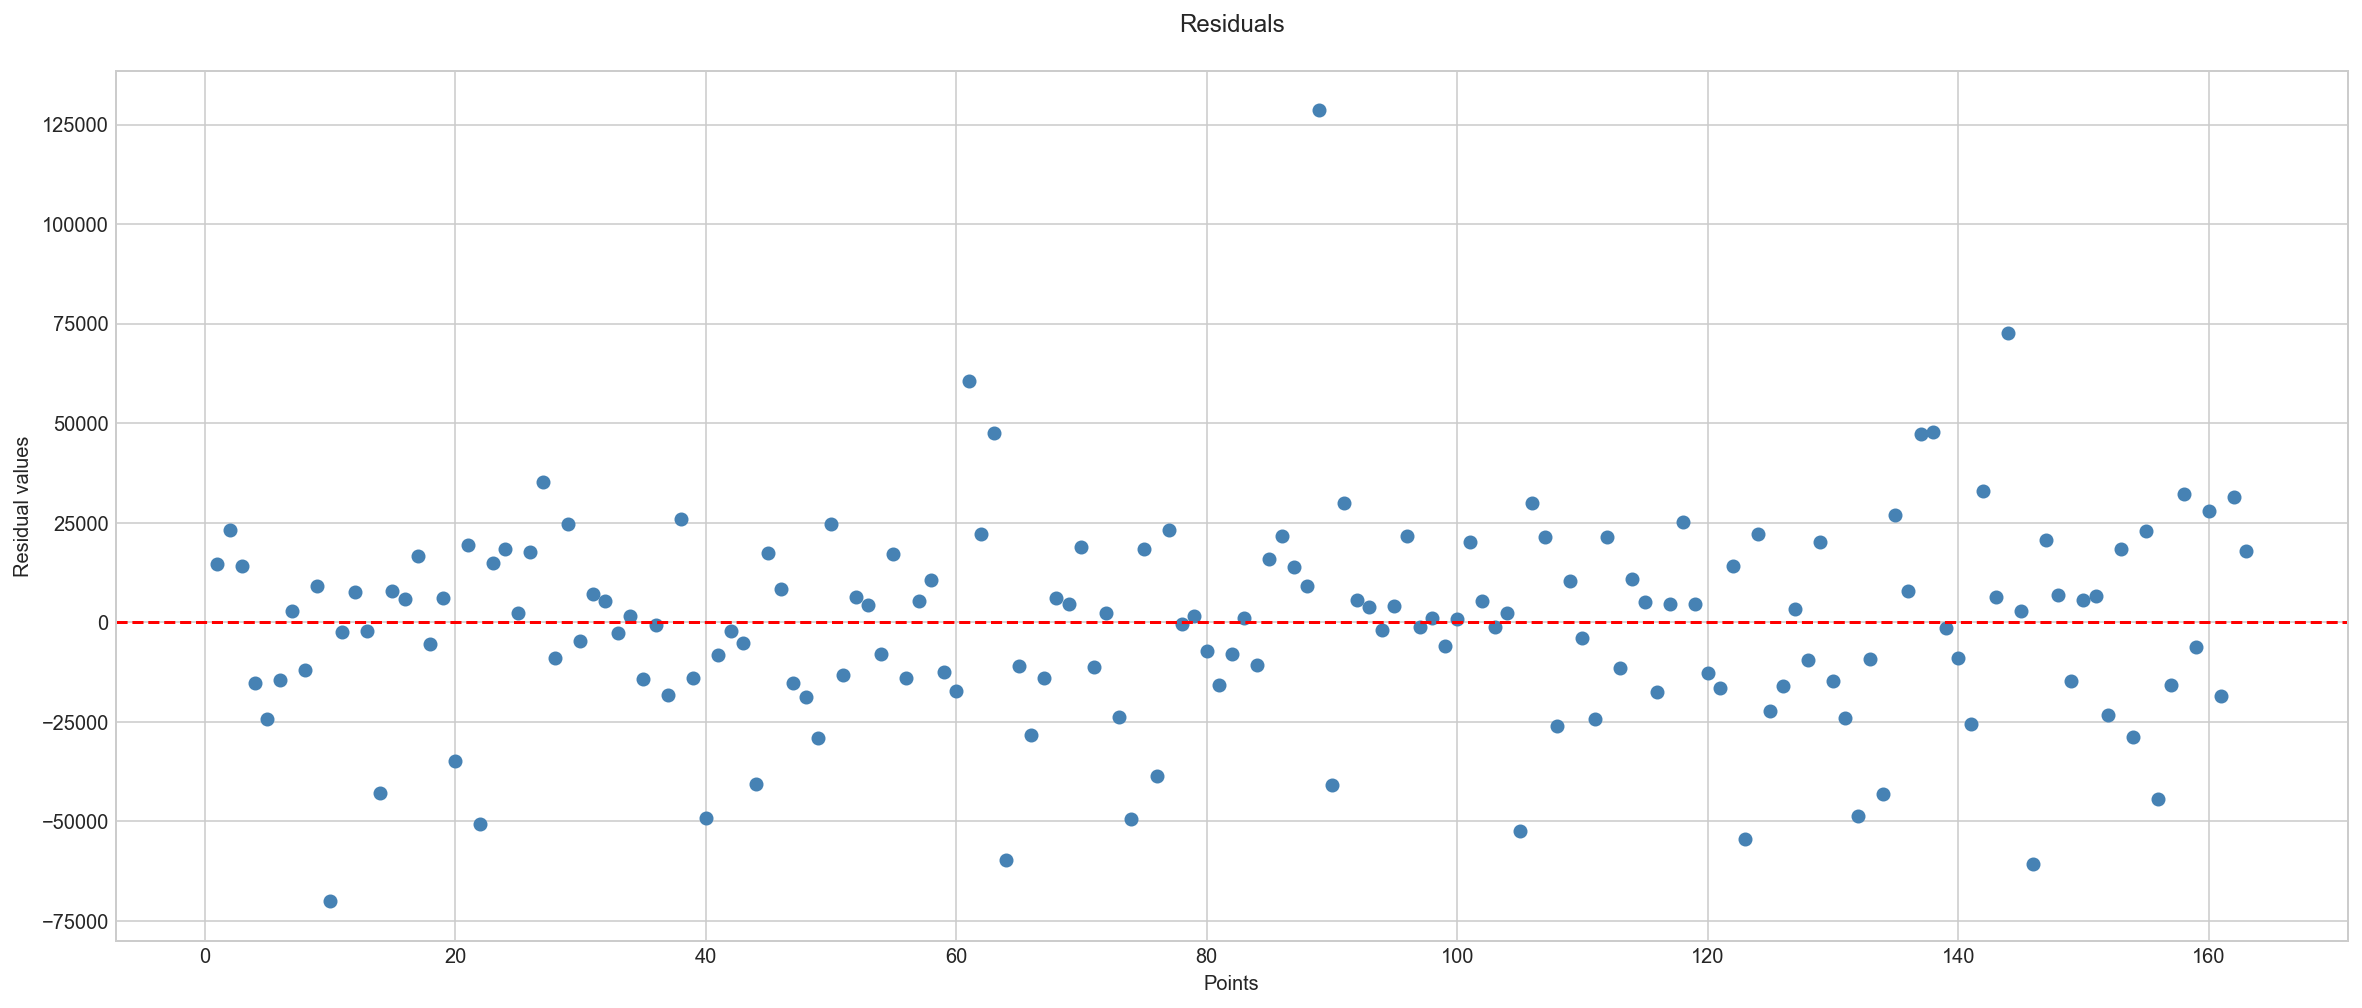

In [57]:
plt.figure(figsize=(20,8))
plt.scatter(range(1,164), (y_test-lr_yhat),  color='steelblue')
plt.axhline(y=0, color='red', linestyle='dashed')

plt.title('Residuals\n')
plt.xlabel('Points')
plt.ylabel('Residual values')
plt.show()

> Kinda random, which is good. Our linear model is kinda working.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [58]:
renovation_features = ['Utilities','OverallQual', 'OverallCond','RoofStyle','RoofMatl','Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 'ExterCond', 
                       'Foundation', 'BsmtCond','BsmtExposure', 'BsmtFinType1','BsmtFinType2','Heating', 'HeatingQC','CentralAir', 'Electrical', 'BedroomAbvGr', 
                       'KitchenAbvGr', 'KitchenQual','TotRmsAbvGrd','Functional','FireplaceQu','GarageFinish','GarageQual', 'GarageCond', 'PavedDrive','PoolQC', 
                       'Fence']

In [59]:
reno_features = df[renovation_features].copy()

In [60]:
# Convert all int64 columns to dtype=category 
# One by one, as .astype('category') doesn't support multiple conversions
reno_features['OverallQual'] = reno_features['OverallQual'].astype('category')
reno_features['OverallCond'] = reno_features['OverallCond'].astype('category')
reno_features['BedroomAbvGr'] = reno_features['BedroomAbvGr'].astype('category')
reno_features['KitchenAbvGr'] = reno_features['KitchenAbvGr'].astype('category')
reno_features['TotRmsAbvGrd'] = reno_features['TotRmsAbvGrd'].astype('category')

In [61]:
reno_features = pd.get_dummies(reno_features, drop_first=True)

In [62]:
reno_features.shape

(1308, 165)

In [63]:
# Get the predicted price for all 

X_all = features.iloc[:,2:].copy()
X_all = scaler.fit_transform(X_all)
lr_yhat_all = lr.predict(X_all)

In [64]:
residuals_df = pd.DataFrame({'residuals':(features['SalePrice']-lr_yhat_all)})

In [65]:
residuals_df.head()

,residuals
0,10352.852343
1,-24535.496602
2,16419.135710
3,-48275.372618
4,-51270.494854


In [66]:
residuals_df.describe()

,residuals
count,1308.000000
mean,-43.122959
std,27923.428878
min,-124454.646542
25%,-13908.602727
50%,311.554716
75%,14246.227776
max,196306.392397


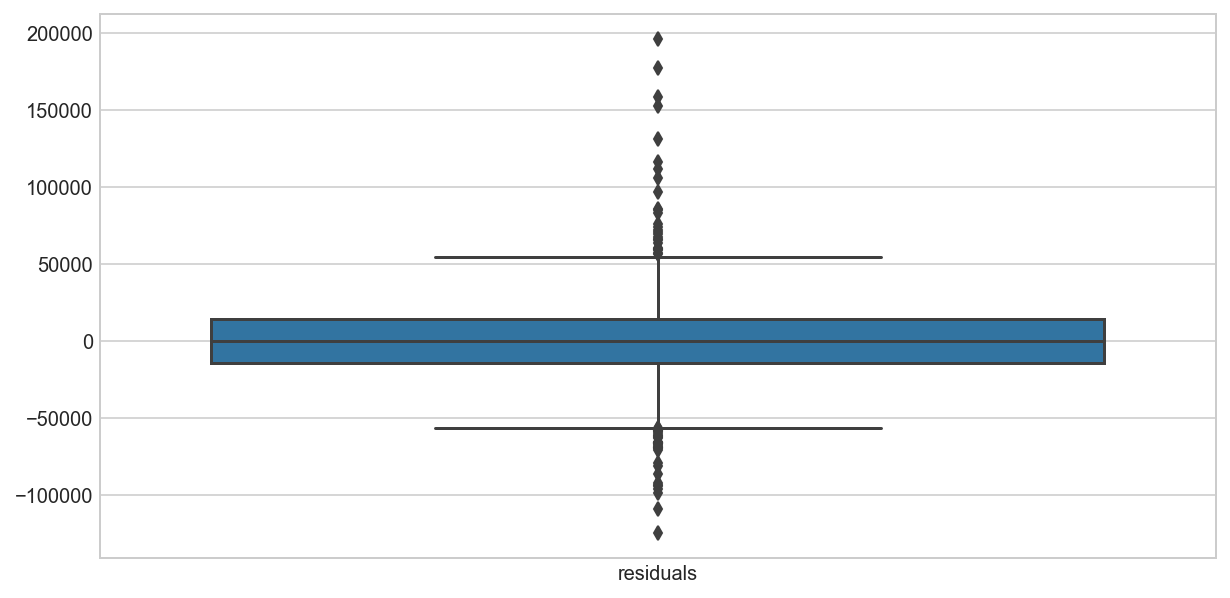

In [67]:
plt.figure(figsize=(10,5))
sns.boxplot(data=residuals_df)
plt.show()

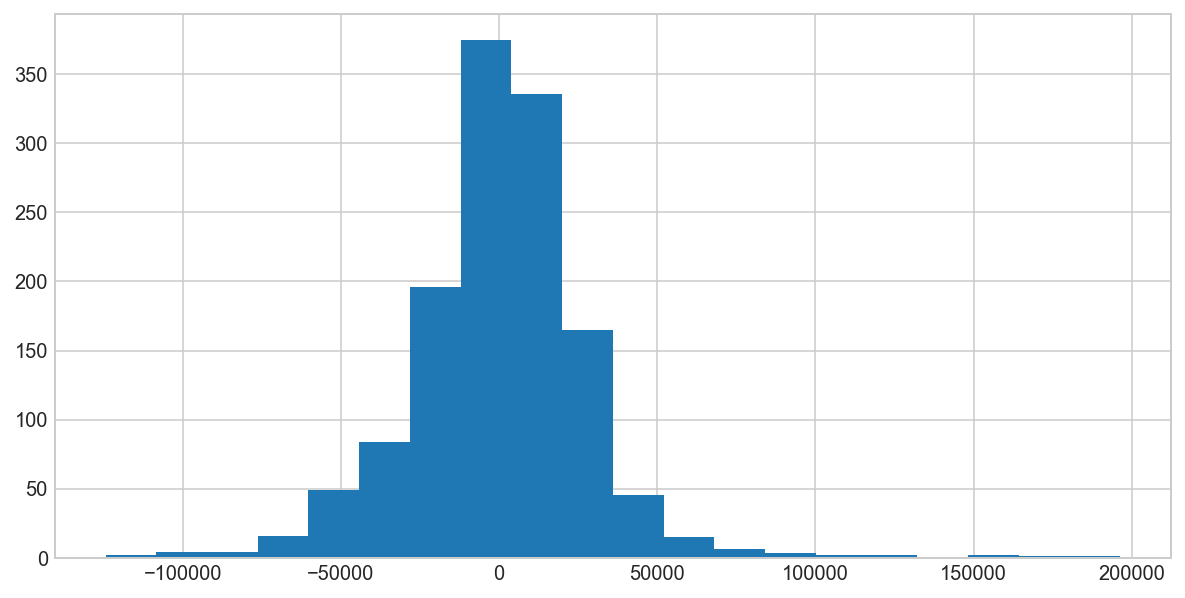

In [68]:
plt.figure(figsize=(10,5))
plt.hist(residuals_df['residuals'], bins=20)
plt.show()

In [69]:
cutoff = np.median(residuals_df['residuals'])

In [70]:
criteria1 = (residuals_df['residuals'] > cutoff)
criteria2 = (residuals_df['residuals'] < cutoff)

In [71]:
residuals_df.loc[criteria1, 'residual_cat'] = 'Yes'
residuals_df.loc[criteria2, 'residual_cat'] = 'No'

In [72]:
residuals_df.head()

,residuals,residual_cat
0,10352.852343,Yes
1,-24535.496602,No
2,16419.135710,Yes
3,-48275.372618,No
4,-51270.494854,No


In [73]:
reno_features = pd.concat([reno_features,residuals_df['residual_cat']], axis=1)

> ----
> **Classification Baseline**
>
> Baseline and KNN

In [74]:
# Baseline using .value_counts()
reno_features['residual_cat'].value_counts()

Yes    654
No     654
Name: residual_cat, dtype: int64

In [75]:
1 - float(645)/float((reno_features['residual_cat'].count()))

0.5068807339449541

In [76]:
# Train and Test matrix
X = reno_features.iloc[:,:-1]
y = reno_features['residual_cat'].values

In [77]:
X = scaler.fit_transform(X)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [79]:
# Classification with KNN, no optimization (k=5)
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.5871559633027523

In [80]:
# Check against cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)

0.5894480328831475

> Better than baseline.

In [81]:
clf_yhat = clf.predict(X_test)

In [82]:
print(classification_report(y_test, clf_yhat))

             precision    recall  f1-score   support

         No       0.57      0.58      0.57       157
        Yes       0.60      0.59      0.60       170

avg / total       0.59      0.59      0.59       327



Confusion matrix, without normalization
[[ 91  66]
 [ 69 101]]


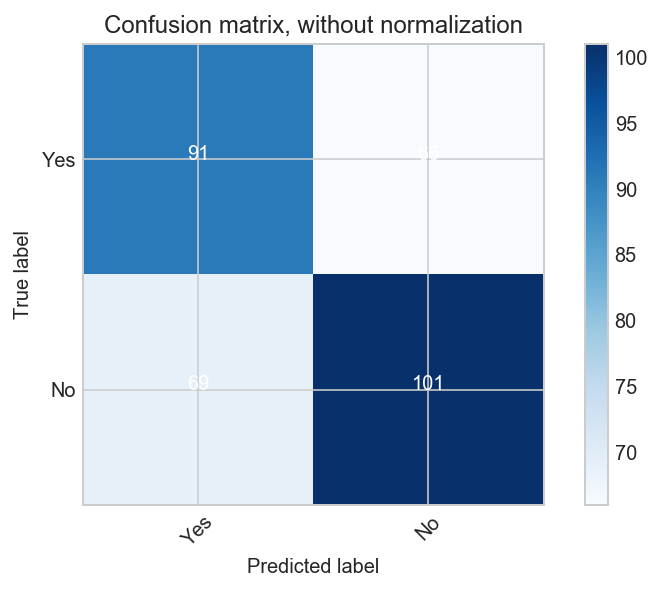

In [83]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, clf_yhat), classes=reno_features['residual_cat'].unique().tolist(),
                      title='Confusion matrix, without normalization')

> Ok. Nubbad...

> ----
> **LogisticRegression**

In [84]:
# Classification with LogisticRegression with no optimization (l2 by default)
lg = LogisticRegression()
lg.fit(X_train,y_train)
lg.score(X_test,y_test)

0.6391437308868502

In [85]:
# Check against cross_val_score
scores_lg = cross_val_score(lg, X, y, cv=5)
np.mean(scores_lg)

0.6620551967116853

In [86]:
lg_yhat = clf.predict(X_test)

In [87]:
print(classification_report(y_test, lg_yhat))

             precision    recall  f1-score   support

         No       0.57      0.58      0.57       157
        Yes       0.60      0.59      0.60       170

avg / total       0.59      0.59      0.59       327



Confusion matrix, without normalization
[[ 91  66]
 [ 69 101]]


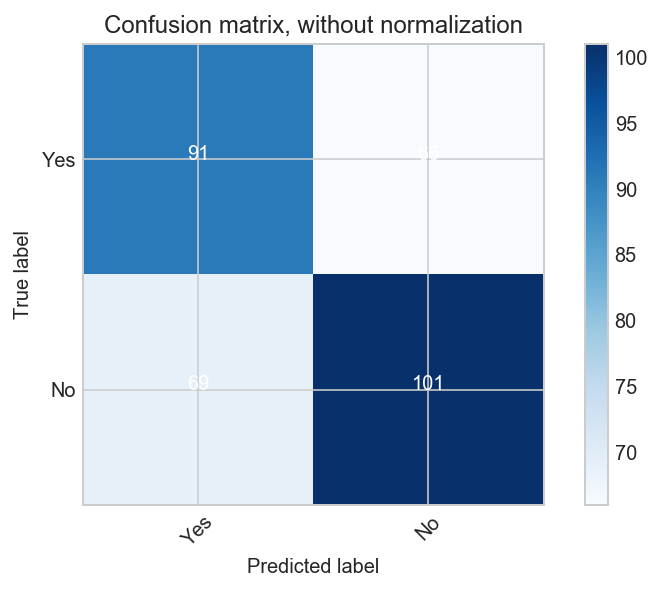

In [88]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, lg_yhat), classes=reno_features['residual_cat'].unique().tolist(),
                      title='Confusion matrix, without normalization')

> With a slightly better cross_val_score, time to tune LogisticRegression model further.

In [89]:
# Using L1 (Lasso) parameters in LogisticRegression

In [90]:
lg_lasso = LogisticRegression(penalty='l1')
lg_lasso.fit(X_train,y_train)
lg_lasso.score(X_test,y_test)

0.6391437308868502

In [91]:
# Check against cross_val_score
scores_lg_lasso = cross_val_score(lg_lasso, X, y, cv=5)
np.mean(scores_lg_lasso)

0.662824427480916

In [92]:
lg_lasso_yhat = clf.predict(X_test)

In [93]:
print(classification_report(y_test, lg_lasso_yhat))

             precision    recall  f1-score   support

         No       0.57      0.58      0.57       157
        Yes       0.60      0.59      0.60       170

avg / total       0.59      0.59      0.59       327



Confusion matrix, without normalization
[[ 91  66]
 [ 69 101]]


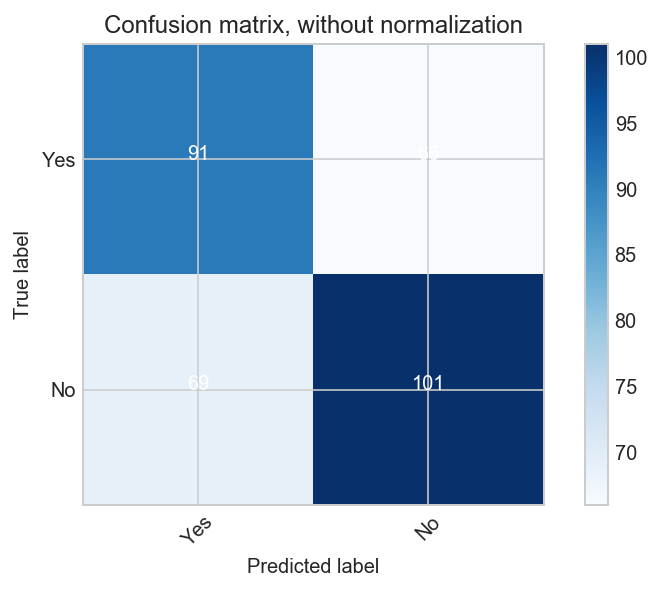

In [94]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, lg_lasso_yhat), classes=reno_features['residual_cat'].unique().tolist(),
                      title='Confusion matrix, without normalization')

In [95]:
lg_lasso_mean_coef = np.mean(lg_lasso.coef_, axis=0)

In [96]:
lg_lasso_coef_df = pd.DataFrame({'labels':reno_features.columns.values[1:],'coef':lg_lasso_mean_coef,
                                 'absolute_coef':np.abs(lg_lasso_mean_coef)
                                })

In [97]:
lg_lasso_coef_df.head()

,absolute_coef,coef,labels
0,0.118110,-0.118110,OverallQual_2
1,0.125840,0.125840,OverallQual_3
2,0.003712,-0.003712,OverallQual_4
3,0.000000,0.000000,OverallQual_5
4,0.223620,-0.223620,OverallQual_6


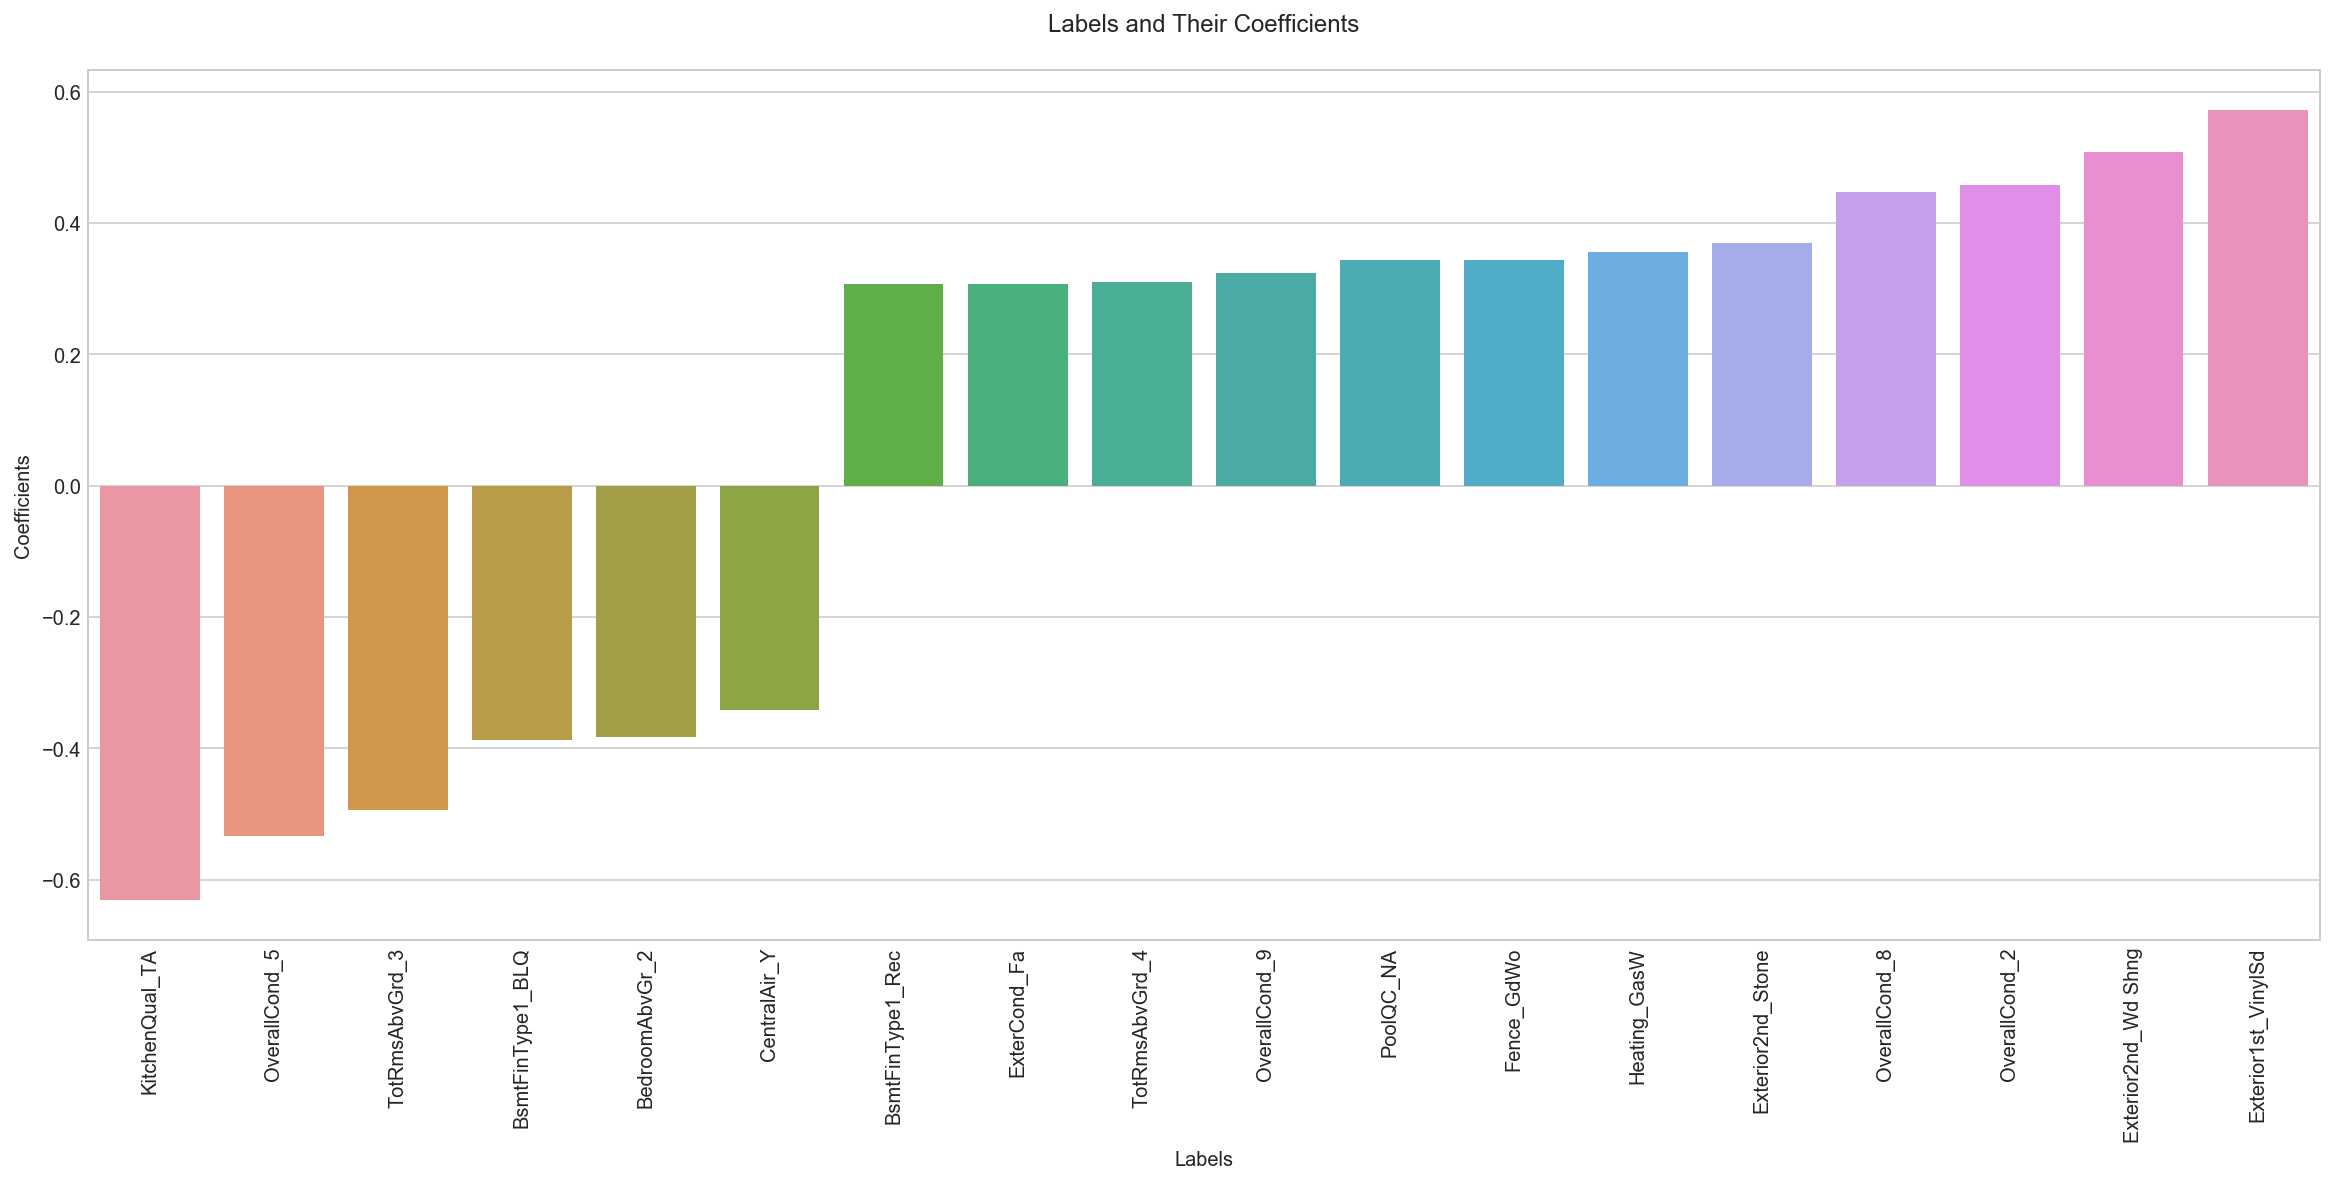

In [98]:
plt.figure(figsize=(20,8))
sns.barplot(data=lg_lasso_coef_df[(lg_lasso_coef_df['absolute_coef']!=0) & (lg_lasso_coef_df['absolute_coef']>0.3)].sort_values(by='coef', ascending=True),
            x='labels', y='coef')

plt.title('Labels and Their Coefficients\n')
plt.ylabel('Coefficients')
plt.xlabel('Labels')
plt.xticks(rotation='vertical')
plt.show()

In [99]:
# # Let's make life easier by using only these head(5) and tail(5) features
# top10_features = ['KitchenQual_TA','OverallCond_5','TotRmsAbvGrd_3','BsmtFinType1_BLQ','BedroomAbvGr_2', 'Exterior2nd_Stone','OverallCond_8','OverallCond_2',
#                   'Exterior2nd_Wd Shng','Exterior1st_VinylSd','residual_cat']

In [100]:
# top10 = reno_features[top10_features].copy()

In [101]:
# top10.shape

In [102]:
# X = top10.iloc[:,:-1]
# y = top10['residual_cat'].values

In [103]:
# X = scaler.fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [104]:
# LogisticRegressionCV
lg_cv = LogisticRegressionCV(Cs=100, 
                             cv=5, 
                             penalty='l1', 
                             scoring='accuracy',  
                             solver='liblinear',
                             verbose=1,
                             n_jobs=-1)
lg_cv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
           refit=True, scoring='accuracy', solver='liblinear', tol=0.0001,
           verbose=1)

In [106]:
# With best C 
logreg_opt = LogisticRegression(C=lg_cv.C_[0], 
                                penalty='l1', 
                                solver='liblinear', 
                                multi_class = 'ovr', 
                                verbose=1)
logreg_opt.fit(X_train,y_train)

[LibLinear]

LogisticRegression(C=0.20565123083486536, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=1, warm_start=False)

In [107]:
logreg_opt.score(X_test,y_test)

0.654434250764526

In [108]:
scores_logreg_opt = cross_val_score(logreg_opt, X, y, cv=5)
np.mean(scores_logreg_opt)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

0.6827187316500293

In [109]:
logreg_opt_yhat = logreg_opt.predict(X_test)

In [110]:
print(classification_report(y_test, logreg_opt_yhat))

             precision    recall  f1-score   support

         No       0.63      0.67      0.65       157
        Yes       0.68      0.64      0.66       170

avg / total       0.66      0.65      0.65       327



Confusion matrix, without normalization
[[105  52]
 [ 61 109]]


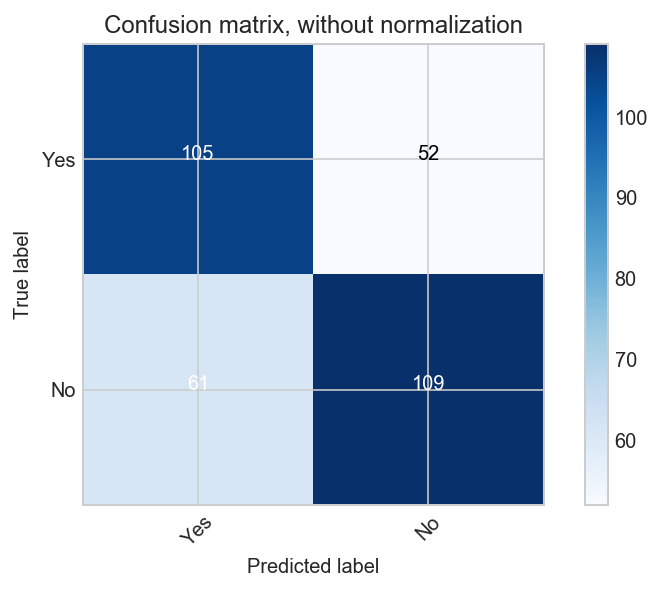

In [111]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, logreg_opt_yhat), classes=reno_features['residual_cat'].unique().tolist(),
                      title='Confusion matrix, without normalization')

> - If I use only those the top10 features, I am getting a lower f1-score AND higher False Positives which we want to minimize (!!).
> - Re-ran test with all features. Took 1.8mins on workhorse PC. Much better scores. Looks like top 10 features is not enough...
> - But, scores are MUCH MUCH better.

In [ ]:
# Google which is better with tons of binary data.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: